# Confronto tra un numero fissato di trotter steps e uno in aumento

In questo notebook proviamo a confrontare due curve: una con 12 trotter steps fissati dall'inizio, e una che arriva a 12 trotter steps nell'intervallo aumentandone il numero ad ogni dt.



## 12 TROTTER STEPS
Facciamo un primo tentativo con un intervallo di T = 3 sec e con un dt di 12 steps, in modo che a T = 3 arrivi con esattamente 12 trotter_steps, quindi ad ogni time step corrisponde un trotter step aggiuntivo

Trotter_steps_fixed = 12 T = 3 t_steps (time step) = 12 dt = 3/12 = 0.25

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit_ibm_runtime import QiskitRuntimeService
 


from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.noise import (QuantumError, depolarizing_error, amplitude_damping_error, phase_damping_error, pauli_error)
from qiskit.providers import Options

#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t


#creazione del NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)


fake_backend = FakeManilaV2()
noise_model = NoiseModel.from_backend(fake_backend)

12 fixed steps completed
1 steps completed
2 steps completed
3 steps completed
4 steps completed
5 steps completed
6 steps completed
7 steps completed
8 steps completed
9 steps completed
10 steps completed
11 steps completed
12 steps completed


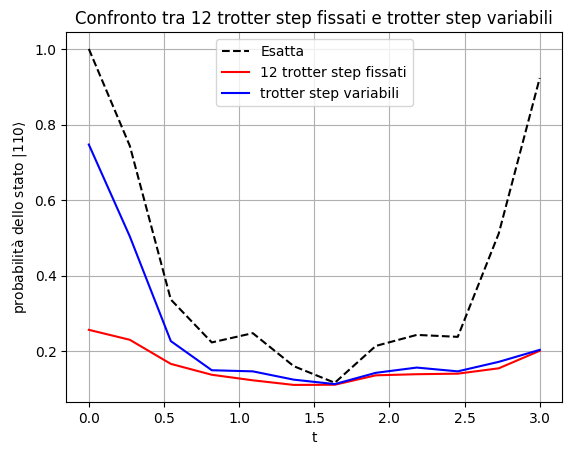

In [46]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 12 #così ogni step è di 0.25
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
ts = np.linspace(0, 3, t_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 12
trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore 
probs_fixed = [] #depositiamo i valori con trotter step fissati = 12
probs_variable = []
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)

#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)

    
print("12 fixed steps completed")

#facciamo andare il circuito con trotter step variabili
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)

    
    print(str(trotter_steps_variable) + " steps completed")
    trotter_steps_variable = trotter_steps_variable + 1 

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="12 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 12 trotter step fissati e trotter step variabili')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed12_vs_variable.png')
plt.show()

## 60 TROTTER STEP

60fixed steps completed
1 steps completed
2 steps completed
3 steps completed
4 steps completed
5 steps completed
6 steps completed
7 steps completed
8 steps completed
9 steps completed
10 steps completed
11 steps completed
12 steps completed
13 steps completed
14 steps completed
15 steps completed
16 steps completed
17 steps completed
18 steps completed
19 steps completed
20 steps completed
21 steps completed
22 steps completed
23 steps completed
24 steps completed
25 steps completed
26 steps completed
27 steps completed
28 steps completed
29 steps completed
30 steps completed
31 steps completed
32 steps completed
33 steps completed
34 steps completed
35 steps completed
36 steps completed
37 steps completed
38 steps completed
39 steps completed
40 steps completed
41 steps completed
42 steps completed
43 steps completed
44 steps completed
45 steps completed
46 steps completed
47 steps completed
48 steps completed
49 steps completed
50 steps completed
51 steps completed
52 steps complet

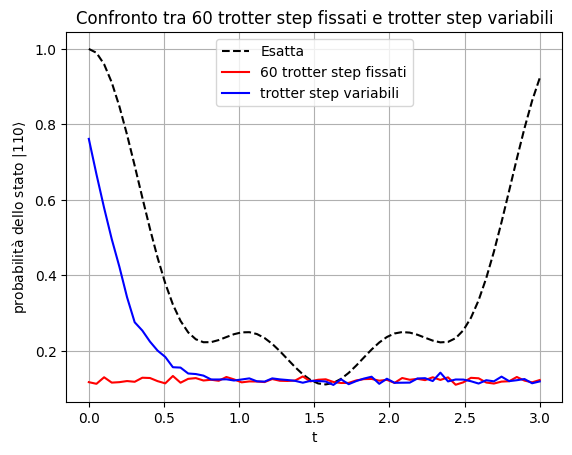

In [47]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 60 #così ogni step è di 0.05
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
ts = np.linspace(0, 3, t_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 60
trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore 
probs_fixed = [] #depositiamo i valori con trotter step fissati = 12
probs_variable = []
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)

#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)

    
print(str(trotter_steps_fixed) + "fixed steps completed")

#facciamo andare il circuito con trotter step variabili
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)

    
    print(str(trotter_steps_variable) + " steps completed")
    
    trotter_steps_variable = trotter_steps_variable + 1 

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="60 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 60 trotter step fissati e trotter step variabili')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed60_vs_variable.png')
plt.show()

## 12 TROTTER STEP FISSATI VS VARIABILI FINO A 60

12fixed steps completed
1 steps completed
2 steps completed
3 steps completed
4 steps completed
5 steps completed
6 steps completed
7 steps completed
8 steps completed
9 steps completed
10 steps completed
11 steps completed
12 steps completed
13 steps completed
14 steps completed
15 steps completed
16 steps completed
17 steps completed
18 steps completed
19 steps completed
20 steps completed
21 steps completed
22 steps completed
23 steps completed
24 steps completed
25 steps completed
26 steps completed
27 steps completed
28 steps completed
29 steps completed
30 steps completed
31 steps completed
32 steps completed
33 steps completed
34 steps completed
35 steps completed
36 steps completed
37 steps completed
38 steps completed
39 steps completed
40 steps completed
41 steps completed
42 steps completed
43 steps completed
44 steps completed
45 steps completed
46 steps completed
47 steps completed
48 steps completed
49 steps completed
50 steps completed
51 steps completed
52 steps complet

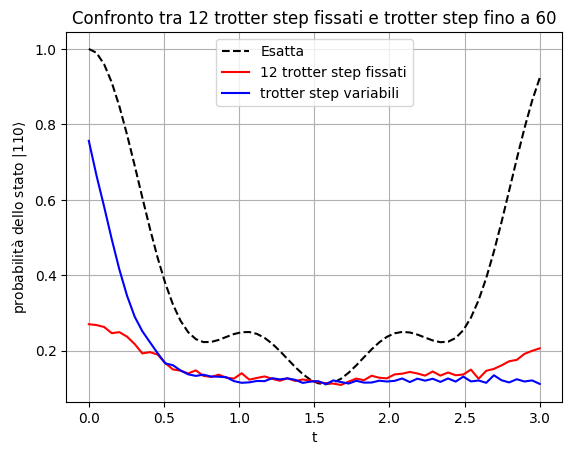

In [48]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 60 #così ogni step è di 0.05
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
ts = np.linspace(0, 3, t_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 12
trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore 
probs_fixed = [] #depositiamo i valori con trotter step fissati = 12
probs_variable = []
simulator = AerSimulator(noise_model=noise_model)
estimator = BackendEstimator(backend=simulator)
pm = generate_preset_pass_manager(optimization_level=0)

#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)

    
print(str(trotter_steps_fixed) + "fixed steps completed")

#facciamo andare il circuito con trotter step variabili
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)

    
    print(str(trotter_steps_variable) + " steps completed")
    
    trotter_steps_variable = trotter_steps_variable + 1 

#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="12 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 12 trotter step fissati e trotter step fino a 60')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed12_vs_variable60.png')
plt.show()